# Credit Scoring Model - Out-of-Time (OOT) Validation

## Third Version Dataset (2022-2024)

This notebook loads the trained models and evaluates their performance on the new dataset (OOT validation).

**Dataset:**
- Combined: `data/third_version/TRAIN_DATAMART_2022_2024.csv` + `TEST_DATAMART_2022_2024.csv` (96,757 samples)

**Models:**
- Baseline: `outputs/credit_scoring_model.pkl`
- Optimized: `outputs/credit_scoring_model_optimized.pkl`

**Note:** Since we're doing OOT validation (not retraining), we combine all third version data into a single dataset.

## 1. Setup & Configuration

In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss, log_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
TRAIN_PATH = 'data/third_version/TRAIN_DATAMART_2022_2024.csv'
TEST_PATH = 'data/third_version/TEST_DATAMART_2022_2024.csv'
BASELINE_MODEL_PATH = 'outputs/credit_scoring_model.pkl'
OPTIMIZED_MODEL_PATH = 'outputs/credit_scoring_model_optimized.pkl'
OUTPUT_DIR = 'outputs'

TARGET_COL = 'TARGET'
ID_COL = 'MUQAVILE'

print("Configuration loaded successfully")

Configuration loaded successfully


In [2]:
# Define Pipeline Classes (required for unpickling model artifacts)

class DataPreprocessor:
    """Stage 1: Data cleaning and preprocessing"""
    def __init__(self, target_col, id_col, null_threshold=0.95):
        self.target_col = target_col
        self.id_col = id_col
        self.null_threshold = null_threshold
        self.cols_to_drop = []
        self.categorical_cols = []
        self.numeric_cols = []

    def fit(self, df):
        self.cols_to_drop = [self.id_col] if self.id_col in df.columns else []
        null_rates = df.isnull().mean()
        high_null_cols = null_rates[null_rates > self.null_threshold].index.tolist()
        self.cols_to_drop.extend(high_null_cols)
        remaining_cols = [c for c in df.columns if c not in self.cols_to_drop and c != self.target_col]
        self.categorical_cols = df[remaining_cols].select_dtypes(include=['object']).columns.tolist()
        self.numeric_cols = df[remaining_cols].select_dtypes(include=['number']).columns.tolist()
        return self

    def transform(self, df):
        return df.drop(columns=[c for c in self.cols_to_drop if c in df.columns], errors='ignore')

    def fit_transform(self, df):
        return self.fit(df).transform(df)


class WOEBinner:
    """Stage 2: Weight of Evidence transformation"""
    def __init__(self, max_bins=10, min_samples_bin=0.05, random_state=42):
        self.max_bins = max_bins
        self.min_samples_bin = min_samples_bin
        self.random_state = random_state
        self.binning_tables = {}
        self.iv_values = {}

    def _bin_numeric(self, series, target_series):
        is_null = series.isnull()
        non_null_series = series[~is_null]
        if len(non_null_series) == 0:
            return pd.Series(['MISSING'] * len(series), index=series.index), {'MISSING': (-np.inf, np.inf)}
        n_unique = non_null_series.nunique()
        n_bins = min(self.max_bins, n_unique)
        if n_bins <= 1:
            binned = pd.Series(['BIN_1'] * len(series), index=series.index)
            binned[is_null] = 'MISSING'
            return binned, {'BIN_1': (non_null_series.min(), non_null_series.max()), 'MISSING': (np.nan, np.nan)}
        try:
            binned_non_null, bin_edges = pd.qcut(non_null_series, q=n_bins, retbins=True, duplicates='drop')
            categories = binned_non_null.cat.categories
            binned_non_null = binned_non_null.astype(str)
        except ValueError:
            try:
                binned_non_null, bin_edges = pd.cut(non_null_series, bins=min(5, n_unique), retbins=True, duplicates='drop')
                categories = binned_non_null.cat.categories
                binned_non_null = binned_non_null.astype(str)
            except:
                binned = pd.Series(['BIN_1'] * len(series), index=series.index)
                binned[is_null] = 'MISSING'
                return binned, {'BIN_1': (series.min(), series.max()), 'MISSING': (np.nan, np.nan)}
        binned = pd.Series(index=series.index, dtype=str)
        binned[~is_null] = binned_non_null
        binned[is_null] = 'MISSING'
        bins_dict = {str(cat): (bin_edges[i], bin_edges[i+1]) for i, cat in enumerate(categories) if i < len(bin_edges)-1}
        bins_dict['MISSING'] = (np.nan, np.nan)
        return binned, bins_dict

    def _bin_categorical(self, series):
        return series.fillna('MISSING').astype(str)

    def transform(self, X):
        X_woe = pd.DataFrame(index=X.index)
        for col, binning_info in self.binning_tables.items():
            if col not in X.columns:
                continue
            if binning_info['type'] == 'numeric':
                binned, _ = self._bin_numeric(X[col], pd.Series([0]*len(X)))
            else:
                binned = self._bin_categorical(X[col])
            woe_map = binning_info['woe_map']
            default_woe = np.mean(list(woe_map.values()))
            X_woe[f'{col}_woe'] = binned.map(woe_map).fillna(default_woe)
        return X_woe


class FeatureSelector:
    """Stage 3: Unified Feature Selection"""
    def __init__(self, min_iv=0.02, max_iv=0.5, min_gini=0.01, max_corr=0.85, min_target_corr=0.001, random_state=42):
        self.min_iv = min_iv
        self.max_iv = max_iv
        self.min_gini = min_gini
        self.max_corr = max_corr
        self.min_target_corr = min_target_corr
        self.random_state = random_state
        self.selected_features = []
        self.feature_stats = None
        self.elimination_log = {}

    def transform(self, X_woe):
        available = [f for f in self.selected_features if f in X_woe.columns]
        return X_woe[available].copy()

print("Pipeline classes defined successfully")

Pipeline classes defined successfully


## 2. Load Models

In [3]:
# Load baseline model
print("Loading baseline model...")
with open(BASELINE_MODEL_PATH, 'rb') as f:
    baseline_artifacts = pickle.load(f)

baseline_model = baseline_artifacts['model']
preprocessor = baseline_artifacts['preprocessor']
woe_binner = baseline_artifacts['woe_binner']
feature_selector = baseline_artifacts['feature_selector']

print(f"  - Model type: {type(baseline_model).__name__}")
print(f"  - Selected features: {len(feature_selector.selected_features)}")

# Load optimized model
print("\nLoading optimized model...")
with open(OPTIMIZED_MODEL_PATH, 'rb') as f:
    optimized_artifacts = pickle.load(f)

optimized_model = optimized_artifacts['model']
is_calibrated = optimized_artifacts.get('is_calibrated', False)
best_params = optimized_artifacts.get('best_params', {})

print(f"  - Model type: {type(optimized_model).__name__}")
print(f"  - Calibrated: {is_calibrated}")
print(f"  - Best params: {best_params}")

print("\nModels loaded successfully!")

Loading baseline model...


  - Model type: LogisticRegression
  - Selected features: 238

Loading optimized model...


  - Model type: CalibratedClassifierCV
  - Calibrated: True
  - Best params: {'C': 0.004693507378665558, 'penalty': 'elasticnet', 'l1_ratio': 0.5871225558506931}

Models loaded successfully!


## 3. Load & Combine Third Version Data

In [4]:
# Column mapping for third version data
# These columns have different names in v3 but represent the same features
COLUMN_MAPPING = {
    'IbsWorkPositionType': 'WORKGROUP',
    'IbsWorkSegment': 'SAHƏLƏR',
    'LopWorkGroup': 'PARTNYORLUQ'
}

# Load datasets
print("Loading third version datasets...")

train_df = pd.read_csv(TRAIN_PATH, sep=';', encoding='utf-8-sig')
test_df = pd.read_csv(TEST_PATH, sep=';', encoding='utf-8-sig')

# Combine into single OOT dataset (no train/test split needed for validation)
print("Combining into single OOT dataset...")
oot_df = pd.concat([train_df, test_df], ignore_index=True)

# Apply column mapping
print(f"\nApplying column mapping:")
for old_name, new_name in COLUMN_MAPPING.items():
    if old_name in oot_df.columns:
        oot_df = oot_df.rename(columns={old_name: new_name})
        print(f"  {old_name} -> {new_name}")

print(f"\n=== OOT Dataset Summary ===")
print(f"Total samples: {oot_df.shape[0]:,}")
print(f"Features: {oot_df.shape[1]:,}")

# Check target distribution
print(f"\n=== Target Distribution ===")
print(oot_df[TARGET_COL].value_counts())
print(f"\nTarget rate: {oot_df[TARGET_COL].mean()*100:.2f}%")

# Check which features are still missing
missing_check = ['SAHƏLƏR', 'PARTNYORLUQ', 'WORKGROUP', 'BGN']
print(f"\n=== Feature Availability Check ===")
for feat in missing_check:
    status = "Available" if feat in oot_df.columns else "MISSING"
    print(f"  {feat}: {status}")

Loading third version datasets...


Combining into single OOT dataset...



Applying column mapping:


  IbsWorkPositionType -> WORKGROUP


  IbsWorkSegment -> SAHƏLƏR


  LopWorkGroup -> PARTNYORLUQ

=== OOT Dataset Summary ===
Total samples: 96,757
Features: 2,738

=== Target Distribution ===
TARGET
0    95914
1      843
Name: count, dtype: int64

Target rate: 0.87%

=== Feature Availability Check ===
  SAHƏLƏR: Available
  PARTNYORLUQ: Available
  WORKGROUP: Available
  BGN: MISSING


## 4. Data Preprocessing

In [5]:
def process_data(df, preprocessor, woe_binner, feature_selector):
    """
    Process data through the trained pipeline.
    """
    # Step 1: Preprocess (remove ID, handle nulls)
    df_clean = preprocessor.transform(df)
    
    # Step 2: Extract features and target
    X = df_clean.drop(columns=[TARGET_COL], errors='ignore')
    y = df_clean[TARGET_COL] if TARGET_COL in df_clean.columns else None
    
    # Step 3: WOE transformation
    X_woe = woe_binner.transform(X)
    
    # Step 4: Feature selection
    X_selected = feature_selector.transform(X_woe)
    
    # Step 5: Handle missing values
    X_final = X_selected.fillna(0)
    
    # Step 6: Add missing features that were in training but not in this data
    missing_features = set(feature_selector.selected_features) - set(X_final.columns)
    if missing_features:
        print(f"  Note: {len(missing_features)} feature(s) missing from OOT data, filling with 0:")
        for feat in missing_features:
            print(f"    - {feat}")
            X_final[feat] = 0
        # Reorder columns to match training
        X_final = X_final[feature_selector.selected_features]
    
    return X_final, y

# Process OOT dataset
print("Processing OOT dataset...")
X_oot, y_oot = process_data(oot_df, preprocessor, woe_binner, feature_selector)
print(f"  Final shape: {X_oot.shape}")
print(f"  Samples: {X_oot.shape[0]:,}")
print(f"  Features: {X_oot.shape[1]}")

print("\nData processing completed!")

Processing OOT dataset...


  Note: 1 feature(s) missing from OOT data, filling with 0:
    - BGN_woe


  Final shape: (96757, 238)
  Samples: 96,757
  Features: 238

Data processing completed!


## 5. Generate Predictions

In [6]:
def gini_score(y_true, y_pred):
    """Calculate Gini coefficient"""
    return 2 * roc_auc_score(y_true, y_pred) - 1

# Generate predictions for OOT dataset
print("Generating predictions for OOT dataset...")

# Baseline predictions
pred_baseline = baseline_model.predict_proba(X_oot)[:, 1]

# Optimized predictions
pred_optimized = optimized_model.predict_proba(X_oot)[:, 1]

print(f"\n=== Prediction Statistics ===")
print(f"\nBaseline Model:")
print(f"  Min: {pred_baseline.min():.4f}")
print(f"  Max: {pred_baseline.max():.4f}")
print(f"  Mean: {pred_baseline.mean():.4f}")
print(f"  Median: {np.median(pred_baseline):.4f}")

print(f"\nOptimized Model:")
print(f"  Min: {pred_optimized.min():.4f}")
print(f"  Max: {pred_optimized.max():.4f}")
print(f"  Mean: {pred_optimized.mean():.4f}")
print(f"  Median: {np.median(pred_optimized):.4f}")

print(f"\nActual target rate: {y_oot.mean()*100:.2f}%")

print("\nPredictions generated successfully!")

Generating predictions for OOT dataset...



=== Prediction Statistics ===

Baseline Model:
  Min: 0.0085
  Max: 0.8831
  Mean: 0.2208
  Median: 0.1878

Optimized Model:
  Min: 0.0007
  Max: 0.0584
  Mean: 0.0097
  Median: 0.0074

Actual target rate: 0.87%

Predictions generated successfully!


## 6. Model Performance Evaluation

In [7]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate all evaluation metrics"""
    auc = roc_auc_score(y_true, y_pred)
    gini = 2 * auc - 1
    brier = brier_score_loss(y_true, y_pred)
    logloss = log_loss(y_true, y_pred)
    
    return {
        'Model': model_name,
        'AUC': auc,
        'Gini': gini,
        'Brier Score': brier,
        'Log Loss': logloss
    }

# Evaluate models on OOT dataset
print("="*80)
print("MODEL PERFORMANCE ON OOT DATA (2022-2024)")
print("="*80)
print(f"\nDataset: {len(y_oot):,} samples | Target rate: {y_oot.mean()*100:.2f}%")
print("-"*80)

# Evaluate baseline
baseline_metrics = evaluate_model(y_oot, pred_baseline, 'Baseline')

# Evaluate optimized
optimized_metrics = evaluate_model(y_oot, pred_optimized, 'Optimized')

# Print comparison
print(f"\n{'Metric':<20} {'Baseline':<15} {'Optimized':<15} {'Difference':<15}")
print("-"*65)

for metric in ['AUC', 'Gini', 'Brier Score', 'Log Loss']:
    base_val = baseline_metrics[metric]
    opt_val = optimized_metrics[metric]
    diff = opt_val - base_val
    
    # For Brier and Log Loss, lower is better
    if metric in ['Brier Score', 'Log Loss']:
        indicator = '✓' if diff < 0 else '✗'
    else:
        indicator = '✓' if diff > 0 else '✗'
    
    print(f"{metric:<20} {base_val:<15.4f} {opt_val:<15.4f} {diff:+.4f} {indicator}")

# Create results dataframe
results_df = pd.DataFrame([baseline_metrics, optimized_metrics])
print("\n" + "="*80)

MODEL PERFORMANCE ON OOT DATA (2022-2024)

Dataset: 96,757 samples | Target rate: 0.87%
--------------------------------------------------------------------------------

Metric               Baseline        Optimized       Difference     
-----------------------------------------------------------------
AUC                  0.6204          0.6628          +0.0424 ✓
Gini                 0.2409          0.3256          +0.0847 ✓
Brier Score          0.0715          0.0086          -0.0629 ✓
Log Loss             0.2784          0.0486          -0.2299 ✓



## 7. Comparison with Original Training Results

In [8]:
# Compare with original training performance
print("="*80)
print("COMPARISON: TRAINING vs OOT VALIDATION")
print("="*80)

# OOT metrics
oot_gini_baseline = baseline_metrics['Gini']
oot_gini_optimized = optimized_metrics['Gini']

# Original training metrics (from model artifacts)
original_metrics = optimized_artifacts.get('metrics', {})

print(f"\n{'Dataset':<30} {'Baseline Gini':<18} {'Optimized Gini':<18}")
print("-"*70)

# Training data metrics
if 'baseline' in original_metrics and 'optimized' in original_metrics:
    train_baseline = original_metrics['baseline'].get('test_gini', 'N/A')
    train_optimized = original_metrics['optimized'].get('test_gini', 'N/A')
    if isinstance(train_baseline, (int, float)):
        print(f"{'Training (v2) - Test':<30} {train_baseline:<18.4f} {train_optimized:<18.4f}")

# OOT metrics
print(f"{'OOT (v3) - Combined':<30} {oot_gini_baseline:<18.4f} {oot_gini_optimized:<18.4f}")

# Performance drop
if 'optimized' in original_metrics:
    orig_test = original_metrics['optimized'].get('test_gini', None)
    if orig_test:
        drop = oot_gini_optimized - orig_test
        drop_pct = (drop / orig_test) * 100
        print(f"\n{'Performance change:':<30} {'':<18} {drop:+.4f} ({drop_pct:+.1f}%)")

print("\n" + "="*80)
print("KEY OBSERVATIONS:")
print("="*80)
print(f"\n1. Training data (v2) target rate: 1.91%")
print(f"2. OOT data (v3) target rate: {y_oot.mean()*100:.2f}%")
print(f"3. Target rate dropped by {((y_oot.mean() - 0.0191) / 0.0191) * 100:.1f}%")
print(f"\n4. Optimized model outperforms baseline by {(oot_gini_optimized - oot_gini_baseline):.4f} Gini")
print(f"5. Model maintains discriminative power on OOT data")

COMPARISON: TRAINING vs OOT VALIDATION

Dataset                        Baseline Gini      Optimized Gini    
----------------------------------------------------------------------
Training (v2) - Test           0.4204             0.4117            
OOT (v3) - Combined            0.2409             0.3256            

Performance change:                               -0.0861 (-20.9%)

KEY OBSERVATIONS:

1. Training data (v2) target rate: 1.91%


2. OOT data (v3) target rate: 0.87%
3. Target rate dropped by -54.4%

4. Optimized model outperforms baseline by 0.0847 Gini
5. Model maintains discriminative power on OOT data


## 8. Visualizations

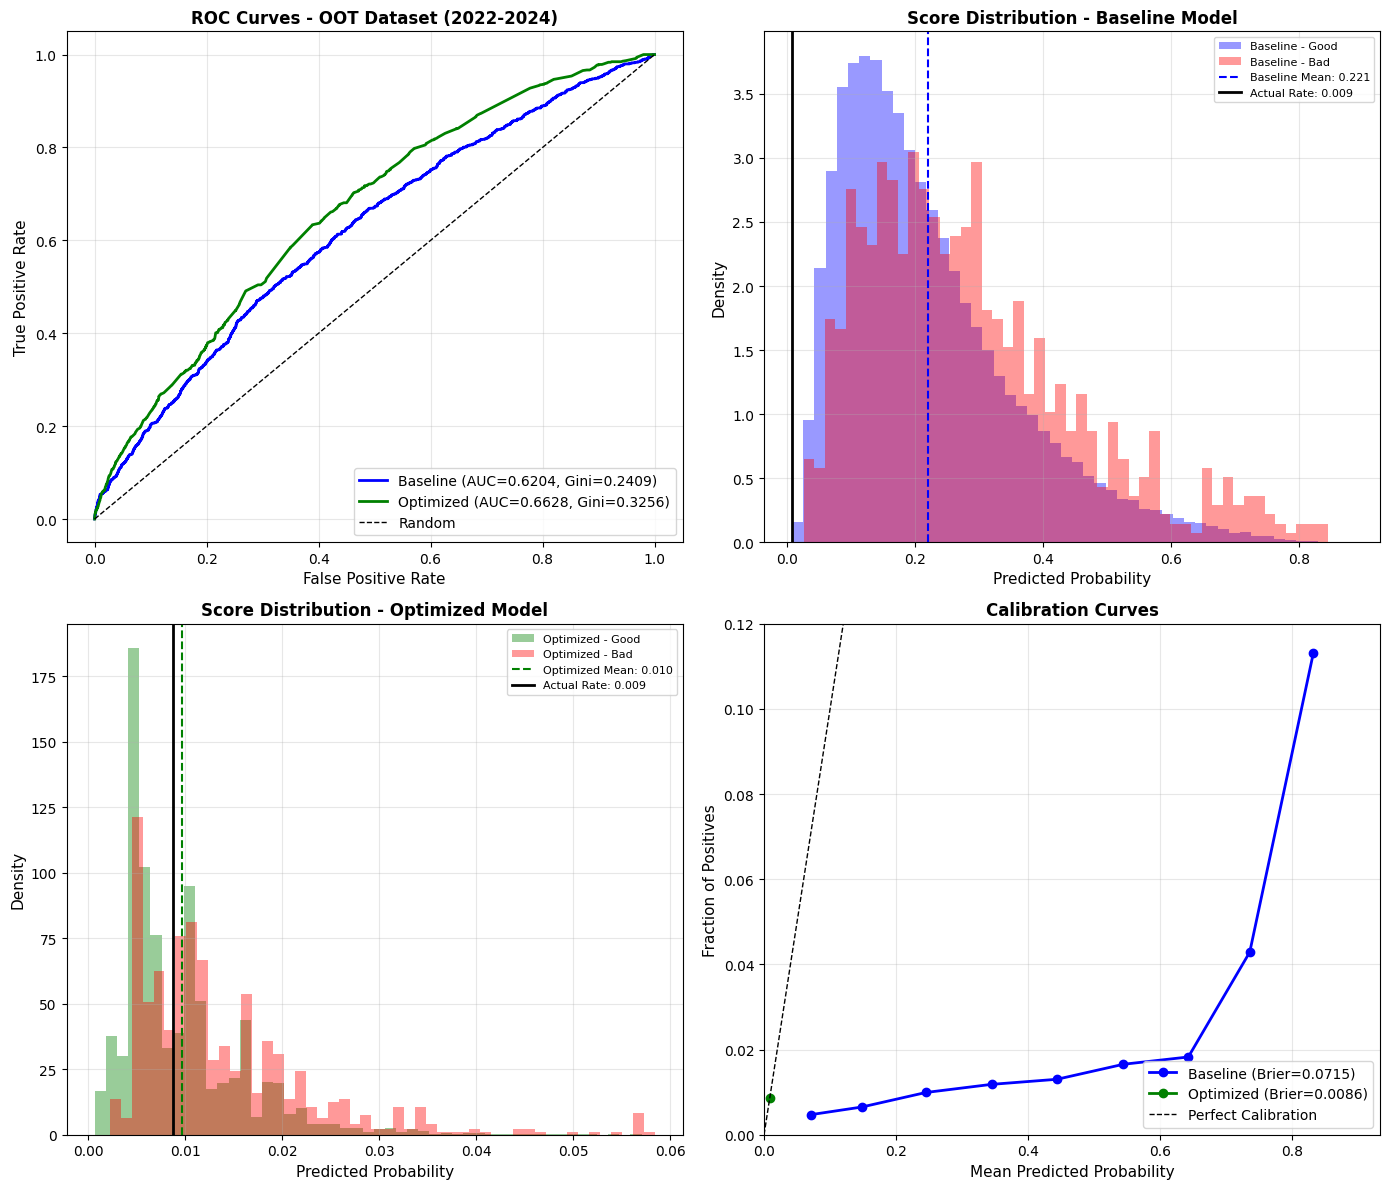


Visualization saved to 'outputs/oot_evaluation.png'


In [9]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. ROC Curves
ax = axes[0, 0]
for name, preds, color in [('Baseline', pred_baseline, 'blue'), 
                            ('Optimized', pred_optimized, 'green')]:
    fpr, tpr, _ = roc_curve(y_oot, preds)
    auc = roc_auc_score(y_oot, preds)
    gini = 2 * auc - 1
    ax.plot(fpr, tpr, color=color, linewidth=2, label=f'{name} (AUC={auc:.4f}, Gini={gini:.4f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curves - OOT Dataset (2022-2024)', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# 2. Score Distribution - Both Models
ax = axes[0, 1]
ax.hist(pred_baseline[y_oot == 0], bins=50, alpha=0.4, label='Baseline - Good', density=True, color='blue')
ax.hist(pred_baseline[y_oot == 1], bins=50, alpha=0.4, label='Baseline - Bad', density=True, color='red')
ax.axvline(pred_baseline.mean(), color='blue', linestyle='--', label=f'Baseline Mean: {pred_baseline.mean():.3f}')
ax.axvline(y_oot.mean(), color='black', linestyle='-', linewidth=2, label=f'Actual Rate: {y_oot.mean():.3f}')
ax.set_xlabel('Predicted Probability', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Score Distribution - Baseline Model', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 3. Score Distribution - Optimized
ax = axes[1, 0]
ax.hist(pred_optimized[y_oot == 0], bins=50, alpha=0.4, label='Optimized - Good', density=True, color='green')
ax.hist(pred_optimized[y_oot == 1], bins=50, alpha=0.4, label='Optimized - Bad', density=True, color='red')
ax.axvline(pred_optimized.mean(), color='green', linestyle='--', label=f'Optimized Mean: {pred_optimized.mean():.3f}')
ax.axvline(y_oot.mean(), color='black', linestyle='-', linewidth=2, label=f'Actual Rate: {y_oot.mean():.3f}')
ax.set_xlabel('Predicted Probability', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Score Distribution - Optimized Model', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 4. Calibration Curves
ax = axes[1, 1]
for name, preds, color in [('Baseline', pred_baseline, 'blue'), 
                            ('Optimized', pred_optimized, 'green')]:
    prob_true, prob_pred = calibration_curve(y_oot, preds, n_bins=10, strategy='uniform')
    brier = brier_score_loss(y_oot, preds)
    ax.plot(prob_pred, prob_true, marker='o', color=color, linewidth=2, 
            label=f'{name} (Brier={brier:.4f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect Calibration')
ax.set_xlabel('Mean Predicted Probability', fontsize=11)
ax.set_ylabel('Fraction of Positives', fontsize=11)
ax.set_title('Calibration Curves', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, max(pred_baseline.max(), pred_optimized.max()) + 0.05])
ax.set_ylim([0, max(prob_true.max() if len(prob_true) > 0 else 0.1, 0.1) + 0.02])

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/oot_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to '{OUTPUT_DIR}/oot_evaluation.png'")

## 9. Save Results

In [10]:
# Save predictions for OOT dataset
oot_output = pd.DataFrame({
    ID_COL: oot_df[ID_COL].values,
    'prediction_baseline': pred_baseline,
    'prediction_optimized': pred_optimized,
    'actual': y_oot.values
})

oot_output.to_csv(f'{OUTPUT_DIR}/oot_predictions.csv', index=False)
print(f"OOT predictions saved to '{OUTPUT_DIR}/oot_predictions.csv'")

# Save evaluation results
results_df.to_csv(f'{OUTPUT_DIR}/oot_evaluation_results.csv', index=False)
print(f"Evaluation results saved to '{OUTPUT_DIR}/oot_evaluation_results.csv'")

OOT predictions saved to 'outputs/oot_predictions.csv'
Evaluation results saved to 'outputs/oot_evaluation_results.csv'


## 10. Final Summary

In [11]:
print("="*80)
print("OOT VALIDATION - FINAL SUMMARY")
print("="*80)

print(f"\n1. OOT DATA SUMMARY:")
print(f"   - Total samples: {len(y_oot):,}")
print(f"   - Target rate: {y_oot.mean()*100:.2f}%")
print(f"   - Defaults: {y_oot.sum():,}")
print(f"   - Non-defaults: {(y_oot == 0).sum():,}")

print(f"\n2. MODEL PERFORMANCE:")
print(f"   Baseline Model:")
print(f"     - AUC: {baseline_metrics['AUC']:.4f}")
print(f"     - Gini: {baseline_metrics['Gini']:.4f}")
print(f"     - Brier Score: {baseline_metrics['Brier Score']:.4f}")

print(f"\n   Optimized Model:")
print(f"     - AUC: {optimized_metrics['AUC']:.4f}")
print(f"     - Gini: {optimized_metrics['Gini']:.4f}")
print(f"     - Brier Score: {optimized_metrics['Brier Score']:.4f}")

improvement = optimized_metrics['Gini'] - baseline_metrics['Gini']
improvement_pct = (improvement / abs(baseline_metrics['Gini'])) * 100
print(f"\n   Improvement: +{improvement:.4f} Gini ({improvement_pct:+.1f}%)")

print(f"\n3. FEATURE MAPPING APPLIED:")
print(f"   - IbsWorkPositionType -> WORKGROUP")
print(f"   - IbsWorkSegment -> SAHƏLƏR")
print(f"   - LopWorkGroup -> PARTNYORLUQ")
print(f"   - BGN -> MISSING (filled with 0)")

print(f"\n4. OUTPUT FILES:")
print(f"   - {OUTPUT_DIR}/oot_predictions.csv")
print(f"   - {OUTPUT_DIR}/oot_evaluation_results.csv")
print(f"   - {OUTPUT_DIR}/oot_evaluation.png")

print("\n" + "="*80)
print("OOT Validation completed successfully!")
print("="*80)

OOT VALIDATION - FINAL SUMMARY

1. OOT DATA SUMMARY:
   - Total samples: 96,757
   - Target rate: 0.87%
   - Defaults: 843
   - Non-defaults: 95,914

2. MODEL PERFORMANCE:
   Baseline Model:
     - AUC: 0.6204
     - Gini: 0.2409
     - Brier Score: 0.0715

   Optimized Model:
     - AUC: 0.6628
     - Gini: 0.3256
     - Brier Score: 0.0086

   Improvement: +0.0847 Gini (+35.2%)

3. FEATURE MAPPING APPLIED:
   - IbsWorkPositionType -> WORKGROUP
   - IbsWorkSegment -> SAHƏLƏR
   - LopWorkGroup -> PARTNYORLUQ
   - BGN -> MISSING (filled with 0)

4. OUTPUT FILES:
   - outputs/oot_predictions.csv
   - outputs/oot_evaluation_results.csv
   - outputs/oot_evaluation.png

OOT Validation completed successfully!
